Files loaded: 3
Time series rows: 868876
Anomalies found: 36643
Saved: /kaggle/working/enrolment_anomalies_with_explanations.csv

Top 10 anomalies:
      date          state          district pincode  total_enrol confidence anomaly_type  z_score   robust_z                                                                   reason
2025-12-15         100000            100000  100000          161       HIGH        SPIKE 3.473533 107.244031 SPIKE | confidence=HIGH | dev=147.8 (1118.4%) | z=3.47 | robust_z=107.24
2025-11-19          ASSAM          SONITPUR  784171          119       HIGH        SPIKE 3.470608  78.915419  SPIKE | confidence=HIGH | dev=108.5 (1033.3%) | z=3.47 | robust_z=78.92
2025-10-30    WEST BENGAL NORTH 24 PARGANAS  743232           29       HIGH        SPIKE 3.466409  36.422501    SPIKE | confidence=HIGH | dev=25.5 (728.6%) | z=3.47 | robust_z=36.42
2025-10-30 MADHYA PRADESH          SHAJAPUR  465106           32       HIGH        SPIKE 3.464154  20.234723    SPIKE | conf

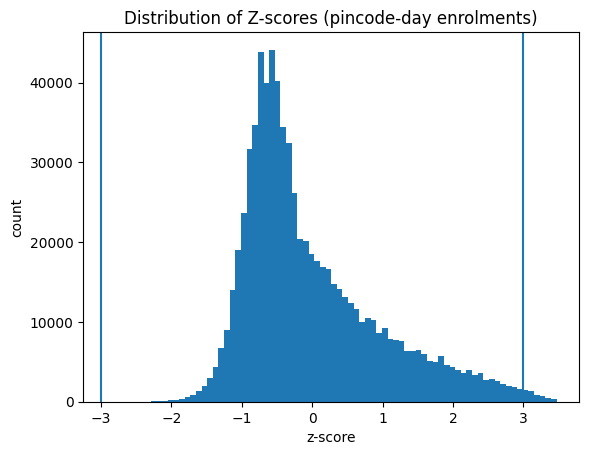

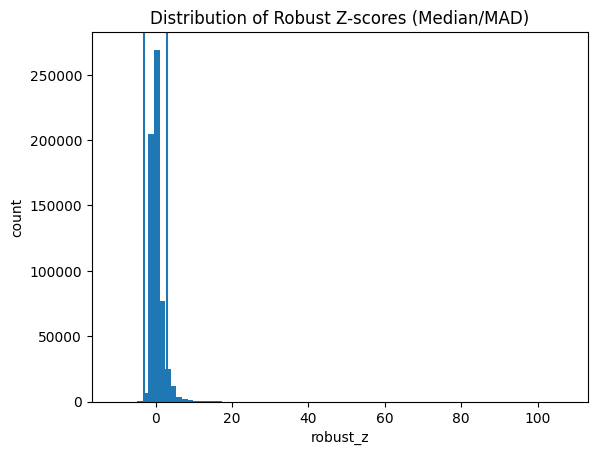

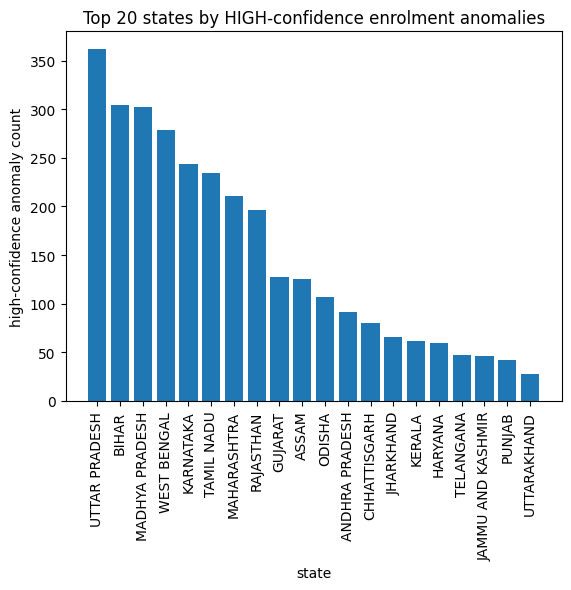

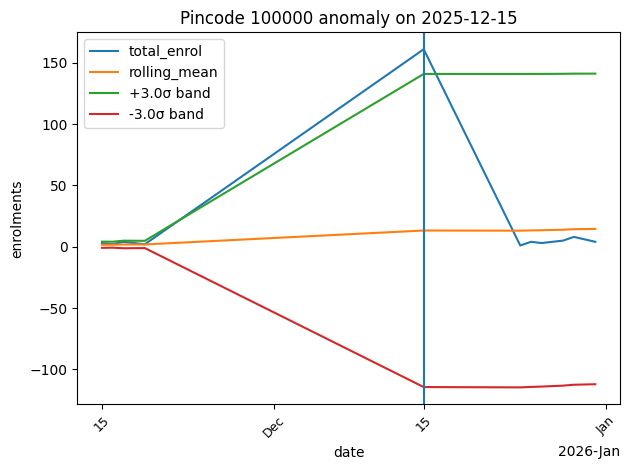

WHY: SPIKE | confidence=HIGH | dev=147.8 (1118.4%) | z=3.47 | robust_z=107.24
 - Z-score method: z=(x-mean)/std. x=161, mean≈13.2, std≈42.5, z=3.47
 - Robust MAD method: robust_z=(x-median)/(1.4826*MAD). x=161, median≈2.0, MAD≈1.0, robust_z=107.24


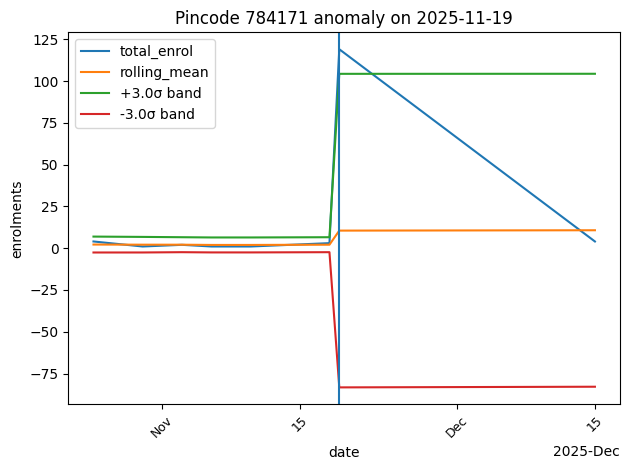

WHY: SPIKE | confidence=HIGH | dev=108.5 (1033.3%) | z=3.47 | robust_z=78.92
 - Z-score method: z=(x-mean)/std. x=119, mean≈10.5, std≈31.3, z=3.47
 - Robust MAD method: robust_z=(x-median)/(1.4826*MAD). x=119, median≈2.0, MAD≈1.0, robust_z=78.92


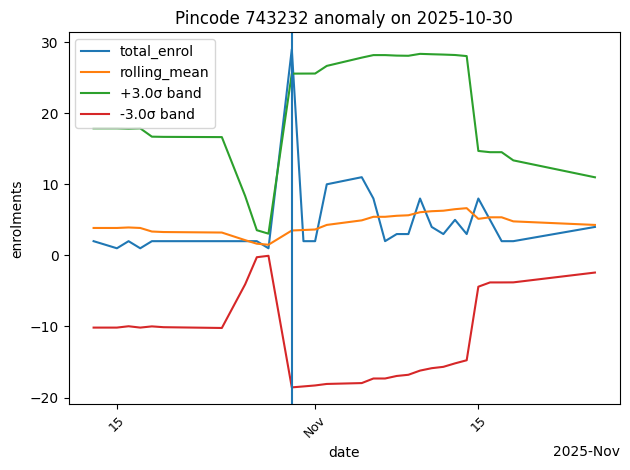

WHY: SPIKE | confidence=HIGH | dev=25.5 (728.6%) | z=3.47 | robust_z=36.42
 - Z-score method: z=(x-mean)/std. x=29, mean≈3.5, std≈7.4, z=3.47
 - Robust MAD method: robust_z=(x-median)/(1.4826*MAD). x=29, median≈2.0, MAD≈0.5, robust_z=36.42


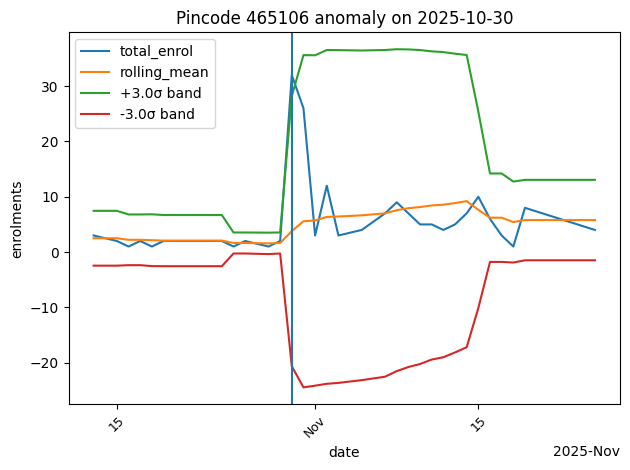

WHY: SPIKE | confidence=HIGH | dev=28.2 (745.3%) | z=3.46 | robust_z=20.23
 - Z-score method: z=(x-mean)/std. x=32, mean≈3.8, std≈8.1, z=3.46
 - Robust MAD method: robust_z=(x-median)/(1.4826*MAD). x=32, median≈2.0, MAD≈1.0, robust_z=20.23


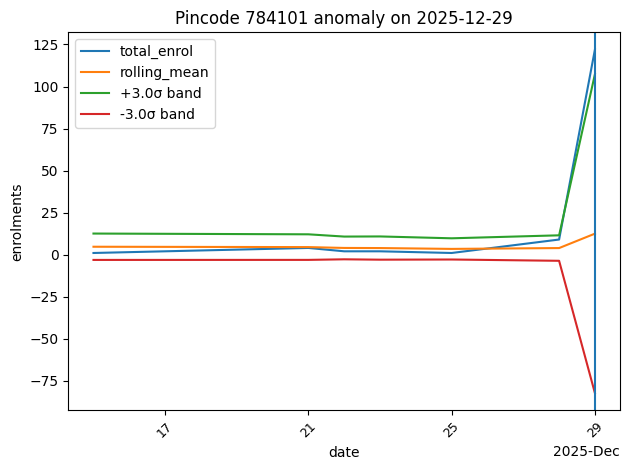

WHY: SPIKE | confidence=HIGH | dev=109.5 (876.0%) | z=3.46 | robust_z=39.79
 - Z-score method: z=(x-mean)/std. x=122, mean≈12.5, std≈31.6, z=3.46
 - Robust MAD method: robust_z=(x-median)/(1.4826*MAD). x=122, median≈4.0, MAD≈2.0, robust_z=39.79


In [3]:
import os
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# =========================
# 0) CONFIG
# =========================
DATA_DIR = "/kaggle/input/enrollment-dataset"  # e.g., Kaggle: "/kaggle/input/enrollment-dataset"
WINDOW = 14
MIN_PERIODS = 7
Z_THRESHOLD = 3.0
TOP_K_PLOTS = 5
CONTEXT_DAYS = 30

# =========================
# 1) LOAD ALL CSV FILES
# =========================
files = sorted(glob(os.path.join(DATA_DIR, "api_data_aadhar_enrolment_*.csv")))
if not files:
    raise FileNotFoundError(f"No enrolment files found in {DATA_DIR}")

usecols = ["date", "state", "district", "pincode", "age_0_5", "age_5_17", "age_18_greater"]
df = pd.concat([pd.read_csv(f, usecols=usecols) for f in files], ignore_index=True)

# =========================
# 2) CLEAN + STANDARDIZE
# =========================
df["date"] = pd.to_datetime(df["date"], format="%d-%m-%Y", errors="coerce")
df = df.dropna(subset=["date"])

df["state"] = df["state"].astype(str).str.strip().str.upper()
df["district"] = df["district"].astype(str).str.strip().str.upper()
df["pincode"] = df["pincode"].astype(str).str.strip().str.zfill(6)

df["total_enrol"] = df["age_0_5"] + df["age_5_17"] + df["age_18_greater"]
df = df.drop_duplicates(subset=["date", "state", "district", "pincode"])

# =========================
# 3) BUILD PINCODE-DAILY TIME SERIES
# =========================
ts = df.groupby(["pincode", "date"], as_index=False)["total_enrol"].sum()
ts = ts.sort_values(["pincode", "date"])

def rolling_mad(x: pd.Series, window: int, min_periods: int):
    def mad_func(arr):
        med = np.median(arr)
        return np.median(np.abs(arr - med))
    return x.rolling(window, min_periods=min_periods).apply(mad_func, raw=True)

# =========================
# 4) METHOD 1: ROLLING Z-SCORE (MEAN + STD)
# =========================
ts["roll_mean"] = ts.groupby("pincode")["total_enrol"].transform(
    lambda s: s.rolling(WINDOW, min_periods=MIN_PERIODS).mean()
)
ts["roll_std"] = ts.groupby("pincode")["total_enrol"].transform(
    lambda s: s.rolling(WINDOW, min_periods=MIN_PERIODS).std()
)
ts.loc[ts["roll_std"] == 0, "roll_std"] = np.nan

ts["z_score"] = (ts["total_enrol"] - ts["roll_mean"]) / ts["roll_std"]
ts["flag_z"] = (ts["z_score"].abs() >= Z_THRESHOLD).astype(int)

# =========================
# 5) METHOD 2: ROBUST Z (MEDIAN + MAD)
# =========================
ts["roll_median"] = ts.groupby("pincode")["total_enrol"].transform(
    lambda s: s.rolling(WINDOW, min_periods=MIN_PERIODS).median()
)

ts["roll_mad"] = ts.groupby("pincode")["total_enrol"].transform(
    lambda s: rolling_mad(s, WINDOW, MIN_PERIODS)
)

ts["robust_scale"] = 1.4826 * ts["roll_mad"]
ts.loc[ts["robust_scale"] == 0, "robust_scale"] = np.nan

ts["robust_z"] = (ts["total_enrol"] - ts["roll_median"]) / ts["robust_scale"]
ts["flag_mad"] = (ts["robust_z"].abs() >= Z_THRESHOLD).astype(int)

# =========================
# 6) CONSOLIDATE ANOMALIES + CONFIDENCE + EXPLANATIONS
# =========================
ts["is_anomaly"] = ((ts["flag_z"] == 1) | (ts["flag_mad"] == 1)).astype(int)

ts["confidence"] = np.where(
    (ts["flag_z"] == 1) & (ts["flag_mad"] == 1),
    "HIGH",
    np.where(ts["is_anomaly"] == 1, "MEDIUM", "NONE")
)

def anomaly_type(row):
    val = row["z_score"]
    if pd.isna(val):
        val = row["robust_z"]
    if pd.isna(val):
        return "UNKNOWN"
    if val >= Z_THRESHOLD:
        return "SPIKE"
    if val <= -Z_THRESHOLD:
        return "DROP"
    return "NORMAL"

ts["anomaly_type"] = ts.apply(anomaly_type, axis=1)

ts["band_upper"] = ts["roll_mean"] + Z_THRESHOLD * ts["roll_std"]
ts["band_lower"] = ts["roll_mean"] - Z_THRESHOLD * ts["roll_std"]

ts["deviation"] = ts["total_enrol"] - ts["roll_mean"]
ts["deviation_pct"] = (ts["deviation"] / ts["roll_mean"]) * 100

ts["explain_z"] = ts.apply(
    lambda r: (
        f"Z-score method: z=(x-mean)/std. x={int(r['total_enrol'])}, "
        f"mean≈{r['roll_mean']:.1f}, std≈{r['roll_std']:.1f}, z={r['z_score']:.2f}"
        if r["flag_z"] == 1 and pd.notna(r["z_score"]) else ""
    ),
    axis=1
)

ts["explain_mad"] = ts.apply(
    lambda r: (
        f"Robust MAD method: robust_z=(x-median)/(1.4826*MAD). x={int(r['total_enrol'])}, "
        f"median≈{r['roll_median']:.1f}, MAD≈{r['roll_mad']:.1f}, robust_z={r['robust_z']:.2f}"
        if r["flag_mad"] == 1 and pd.notna(r["robust_z"]) else ""
    ),
    axis=1
)

ts["reason"] = ts.apply(
    lambda r: (
        f"{r['anomaly_type']} | confidence={r['confidence']} | "
        f"dev={r['deviation']:.1f} ({r['deviation_pct']:.1f}%) | "
        f"z={r['z_score']:.2f} | robust_z={r['robust_z']:.2f}"
        if r["is_anomaly"] == 1 else ""
    ),
    axis=1
)

anoms = ts[ts["is_anomaly"] == 1].copy()

loc = df[["pincode", "state", "district"]].drop_duplicates("pincode")
anoms = anoms.merge(loc, on="pincode", how="left")

anoms["abs_z"] = anoms["z_score"].abs()
anoms["abs_rz"] = anoms["robust_z"].abs()
anoms = anoms.sort_values(["confidence", "abs_z", "abs_rz"], ascending=[True, False, False])

# Save CSV (Kaggle: /kaggle/input is read-only)
OUTPUT_DIR = "/kaggle/working" if os.path.exists("/kaggle/working") else DATA_DIR
out_csv = os.path.join(OUTPUT_DIR, "enrolment_anomalies_with_explanations.csv")
anoms.to_csv(out_csv, index=False)

print("Files loaded:", len(files))
print("Time series rows:", len(ts))
print("Anomalies found:", len(anoms))
print("Saved:", out_csv)

print("\nTop 10 anomalies:")
print(
    anoms[["date","state","district","pincode","total_enrol","confidence","anomaly_type","z_score","robust_z","reason"]]
    .head(10)
    .to_string(index=False)
)

# =========================
# 7) GRAPHS
# =========================
def apply_short_dates(ax, maxticks: int = 6, rotation: int = 45):
    locator = mdates.AutoDateLocator(minticks=3, maxticks=maxticks)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
    ax.tick_params(axis="x", labelrotation=rotation, labelsize=9)
    ax.figure.tight_layout()

# (A) Histogram: z-score distribution + threshold lines
zs = ts["z_score"].dropna()
plt.figure()
plt.hist(zs, bins=80)
plt.axvline(Z_THRESHOLD)
plt.axvline(-Z_THRESHOLD)
plt.title("Distribution of Z-scores (pincode-day enrolments)")
plt.xlabel("z-score")
plt.ylabel("count")
plt.show()

# (B) Histogram: robust_z distribution + threshold lines
rzs = ts["robust_z"].dropna()
plt.figure()
plt.hist(rzs, bins=80)
plt.axvline(Z_THRESHOLD)
plt.axvline(-Z_THRESHOLD)
plt.title("Distribution of Robust Z-scores (Median/MAD)")
plt.xlabel("robust_z")
plt.ylabel("count")
plt.show()

# (C) Top 20 states by HIGH confidence anomalies
high = anoms[anoms["confidence"] == "HIGH"]
if not high.empty:
    by_state = high.groupby("state")["pincode"].count().sort_values(ascending=False).head(20)
    plt.figure()
    plt.bar(by_state.index, by_state.values)
    plt.title("Top 20 states by HIGH-confidence enrolment anomalies")
    plt.xlabel("state")
    plt.ylabel("high-confidence anomaly count")
    plt.xticks(rotation=90)
    plt.show()

# (D) Evidence plot for top anomalies
def plot_anomaly(pincode: str, anomaly_date: pd.Timestamp, days: int = CONTEXT_DAYS):
    p = ts[ts["pincode"] == pincode].copy()
    if p.empty:
        return

    start = anomaly_date - pd.Timedelta(days=days)
    end = anomaly_date + pd.Timedelta(days=days)
    w = p[(p["date"] >= start) & (p["date"] <= end)].copy()
    if w.empty:
        return

    rr = anoms[(anoms["pincode"] == pincode) & (anoms["date"] == anomaly_date)]
    reason_text = rr["reason"].iloc[0] if not rr.empty else ""

    fig, ax = plt.subplots()
    ax.plot(w["date"], w["total_enrol"], label="total_enrol")
    ax.plot(w["date"], w["roll_mean"], label="rolling_mean")
    ax.plot(w["date"], w["band_upper"], label=f"+{Z_THRESHOLD}σ band")
    ax.plot(w["date"], w["band_lower"], label=f"-{Z_THRESHOLD}σ band")
    ax.axvline(anomaly_date)

    ax.set_title(f"Pincode {pincode} anomaly on {anomaly_date.date()}")
    ax.set_xlabel("date")
    ax.set_ylabel("enrolments")
    ax.legend()

    apply_short_dates(ax, maxticks=6, rotation=45)
    plt.show()

    if reason_text:
        print("WHY:", reason_text)
        if not rr.empty:
            if rr["explain_z"].iloc[0]:
                print(" -", rr["explain_z"].iloc[0])
            if rr["explain_mad"].iloc[0]:
                print(" -", rr["explain_mad"].iloc[0])

for _, row in anoms.head(TOP_K_PLOTS).iterrows():
    plot_anomaly(row["pincode"], row["date"], days=CONTEXT_DAYS)
